In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path 
import cv2
import matplotlib.pyplot as plt 
import seaborn as sns
import torch
import torch.nn as nn

In [3]:
image_dir = Path('/kaggle/input/age-prediction/20-50/20-50') #tell python in which directory the training images are.
filepaths = pd.Series(list(image_dir.glob(r'**/*.jpg')), name='Filepath').astype(str)
ages = pd.Series(filepaths.apply(lambda x: os.path.split(os.path.split(x)[0])[1]), name='Age').astype(np.int)
images = pd.concat([filepaths, ages], axis=1).sample(frac=1.0, random_state=1).reset_index(drop=True)
images.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


,Filepath,Age
0,/kaggle/input/age-prediction/20-50/20-50/test/...,38
1,/kaggle/input/age-prediction/20-50/20-50/train...,39
2,/kaggle/input/age-prediction/20-50/20-50/train...,30
3,/kaggle/input/age-prediction/20-50/20-50/train...,42
4,/kaggle/input/age-prediction/20-50/20-50/train...,35


Age: 34


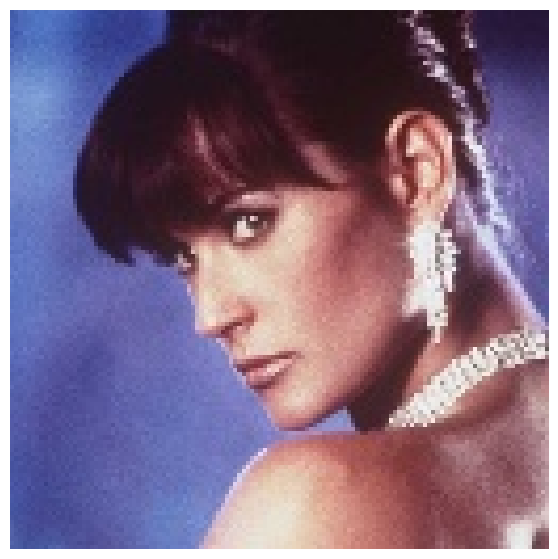

In [4]:
def visualize(image):
    plt.figure(figsize=(7, 7))
    plt.axis('off')
    plt.imshow(image)

#choose an image id to see its age
image_id = 35
image_example_path = images.iloc[image_id].Filepath
age = images.iloc[image_id].Age

print(f'Age: {age}')
image = cv2.imread(image_example_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
visualize(image)

(array([0]), [Text(0, 0, '0')])

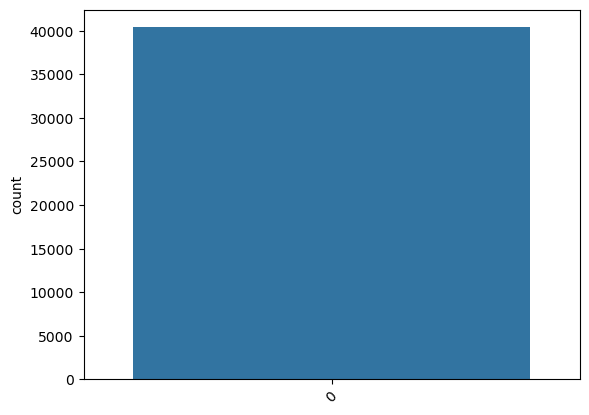

In [5]:
sns.countplot(images.Age)
plt.xticks(rotation = 45)

In [6]:
images.Age = images.Age-20

In [7]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(images, test_size = 0.1, random_state = 1)
train, valid = train_test_split(train, test_size = 0.2, random_state = 1)

In [8]:
class ImageAgeDataset() : 
  def __init__(self , images) : 
    self.age = images.Age.values
    self.paths = images.Filepath.values 

  def __len__(self) : 
    return len(self.age)

  def __getitem__(self , item) : 
    out = dict()
    path = self.paths[item] 
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = np.array(image , dtype = float)
    out['x'] = torch.tensor(image , dtype = torch.float).permute(2,0,1)/255 
    out['y'] = torch.tensor(self.age[item], dtype= torch.long) #CrossEntropyLoss()'s forward(probs, y) function requires torch.long for y
    return out 

In [9]:
train_dataset = ImageAgeDataset(train) 
valid_dataset = ImageAgeDataset(valid)

In [10]:
class AlexNetwork(nn.Module):
    def __init__(self, n_classes):
        super(AlexNetwork, self).__init__()
        self.n_classes = n_classes
        self.conv_1 = nn.Conv2d(
            in_channels = 3,
            out_channels = 96,
            kernel_size = 11,
            stride = 4,
            padding = 50
        )
        self.pool_1 = nn.MaxPool2d(
        kernel_size = 3, 
        stride = 2,
        )
        self.conv_2 = nn.Conv2d(
            in_channels = 96,
            out_channels = 256,
            kernel_size = 5,
            stride = 1,
            padding = 2
        )  
        self.pool_2 = nn.MaxPool2d(
        kernel_size = 3, 
        stride = 2,
        )
        self.conv_3 = nn.Conv2d(
            in_channels = 256,
            out_channels = 384,
            kernel_size = 3,
            stride = 1,
            padding = 1
        )  
        self.conv_4 = nn.Conv2d(
            in_channels = 384,
            out_channels = 384,
            kernel_size = 3,
            stride = 1,
            padding = 1
        )  
        self.conv_5 = nn.Conv2d(
            in_channels = 384,
            out_channels = 256,
            kernel_size = 3,
            stride = 1,
            padding = 1
        ) 
        self.pool_3 = nn.MaxPool2d(
        kernel_size = 3, 
        stride = 2,
        )
        self.nn = nn.Sequential(nn.Linear(in_features = 9216, out_features = 4096),
                                nn.ReLU(),
                                nn.Linear(in_features = 4096, out_features = 4096),
                                nn.ReLU(),
                                nn.Linear(in_features = 4096, out_features = self.n_classes),
                               )
    def forward(self, x):
        x = self.conv_1(x)
        x = self.pool_1(x)
        x = self.conv_2(x)
        x = self.pool_2(x)
        x = self.conv_3(x)
        x = self.conv_4(x)
        x = self.conv_5(x)
        x = self.pool_3(x)
        x = x.view(-1,9216)
        x = self.nn(x)
        return x  

In [11]:
DEVICE = 'cuda' 
BATCH_SIZE = 50
MAX_WAIT = 3
EPOCHS = 100
LR = 1e1

#---------------------
train_dataloader = torch.utils.data.DataLoader(
    dataset = train_dataset,
    batch_size = BATCH_SIZE, 
    shuffle = True ,
    num_workers = 8
)

valid_dataloader = torch.utils.data.DataLoader(
    dataset = valid_dataset,
    batch_size = BATCH_SIZE, 
    shuffle = False,
    num_workers = 8
)
#---------------------
model = AlexNetwork(31)
model.to(DEVICE)
#---------------------
loss_fn = nn.CrossEntropyLoss()
#---------------------
optimizer = torch.optim.Adam(params = model.parameters(), lr = LR)
#---------------------
from tqdm.notebook import tqdm 
import numpy as np 
def train_step(model , optimizer , dataloader): 
  model.train()
  total_loss = 0 
  for data in tqdm(dataloader): 
    x = data["x"].to(DEVICE)
    y = data["y"].to(DEVICE)
    y_hat = model(x).to(DEVICE) #to apply model(x), x and model must be in the same place (device)
    loss = loss_fn(y_hat , y) #enough for y_hat and y to be in the same device
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    total_loss += loss.item()
  #total_loss.backward()
  #optimizer.step()
  #optimizer.zero_grad()
  return total_loss/len(dataloader)

def valid_step(model, dataloader): 
  model.eval()
  total_loss = 0 
  for data in tqdm(dataloader): 
    x = data["x"].to(DEVICE)
    y = data["y"].to(DEVICE)
    with torch.no_grad():
      y_hat = model(x).to(DEVICE)
      loss = loss_fn(y_hat , y) 
    total_loss += loss.item()
  return total_loss/len(dataloader)

def main(model , optimizer , train_dataloader , valid_dataloader ): 
  train_losses = []
  valid_losses = [] 
  min_valid_loss = np.inf 
  patience = 0 
  for epoch in range(EPOCHS): 
    train_loss = train_step(model , optimizer , train_dataloader)
    train_losses.append(train_loss)  
    valid_loss = valid_step(model , valid_dataloader)
    valid_losses.append(valid_loss)
    print(f'EPOCH = {epoch}')
    print(f'train_loss = {train_loss}')
    print(f'valid_loss = {valid_loss}')
    if valid_loss > min_valid_loss : 
      patience += 1 
    else: 
      min_valid_loss = valid_loss 
      patience = 0 

    if patience > MAX_WAIT : 
      print(f'EARLY STOPPING AT EPOCH = {epoch}')
      break 
  return train_losses , valid_losses 

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [12]:
train_losses, valid_losses = main(
    model = model, 
    optimizer = optimizer, 
    train_dataloader = train_dataloader,
    valid_dataloader = valid_dataloader
)

  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 0
train_loss = 1.3664099366467454e+27
valid_loss = 6.46425807076984e+26


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 1
train_loss = 4.890647738158624e+26
valid_loss = 3.8698039294450455e+26


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 2
train_loss = 2.7595163508875095e+26
valid_loss = 1.9288719312948292e+26


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 3
train_loss = 2.178324932648437e+26
valid_loss = 1.5179266423930429e+26


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 4
train_loss = 1.2125075697656395e+26
valid_loss = 9.168930431137951e+25


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 5
train_loss = 8.68717076954916e+25
valid_loss = 7.143291572349162e+25


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 6
train_loss = 7.6511444505149445e+25
valid_loss = 6.349997563947545e+25


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 7
train_loss = 7.5839455417882024e+25
valid_loss = 6.007749342326388e+25


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 8
train_loss = 5.182884264873681e+25
valid_loss = 4.550046593461379e+25


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 9
train_loss = 4.647189472029904e+25
valid_loss = 6.295417612388201e+25


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 10
train_loss = 5.0848811354496575e+25
valid_loss = 5.062240286342232e+25


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 11
train_loss = 5.264506382597e+25
valid_loss = 4.75114275767272e+25


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 12
train_loss = 3.868804831997019e+25
valid_loss = 3.469557316838659e+25


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 13
train_loss = 3.879129248619177e+25
valid_loss = 3.6336755066567898e+25


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 14
train_loss = 3.783368050603918e+25
valid_loss = 3.0578573580544544e+25


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 15
train_loss = 2.8149306733448175e+25
valid_loss = 2.6717088665506632e+25


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 16
train_loss = 2.4893953872269578e+25
valid_loss = 2.3770298442814947e+25


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 17
train_loss = 2.3049787202234687e+25
valid_loss = 2.3081078674427634e+25


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 18
train_loss = 2.5034446027259226e+25
valid_loss = 2.2975622500055606e+25


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 19
train_loss = 2.31269895305059e+25
valid_loss = 2.2199558137558243e+25


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 20
train_loss = 2.0513443226768924e+25
valid_loss = 1.9734083101400538e+25


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 21
train_loss = 1.8463377973303982e+25
valid_loss = 1.8492225666248065e+25


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 22
train_loss = 1.7939368679850045e+25
valid_loss = 3.36698524747058e+25


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 23
train_loss = 1.9356602012511475e+25
valid_loss = 1.8004374919108622e+25


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 24
train_loss = 1.9107235354637244e+25
valid_loss = 1.8550259000704755e+25


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 25
train_loss = 1.6601467432945627e+25
valid_loss = 1.6523438338937996e+25


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 26
train_loss = 1.515239273888955e+25
valid_loss = 1.5600462752349678e+25


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 27
train_loss = 1.4183762550933826e+25
valid_loss = 1.4720841302254968e+25


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 28
train_loss = 1.34250663318572e+25
valid_loss = 1.4190802898799287e+25


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 29
train_loss = 1.4990775578451405e+25
valid_loss = 1.6122081370057214e+25


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 30
train_loss = 1.392770492793936e+25
valid_loss = 1.4299467744530948e+25


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 31
train_loss = 1.2862985286231373e+25
valid_loss = 1.3644589559404557e+25


  0%|          | 0/583 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [13]:
test_dataset = ImageAgeDataset(test)


In [14]:
len(test_dataset)


4044

image 250 is 38 years old and is predicted 39 years old


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


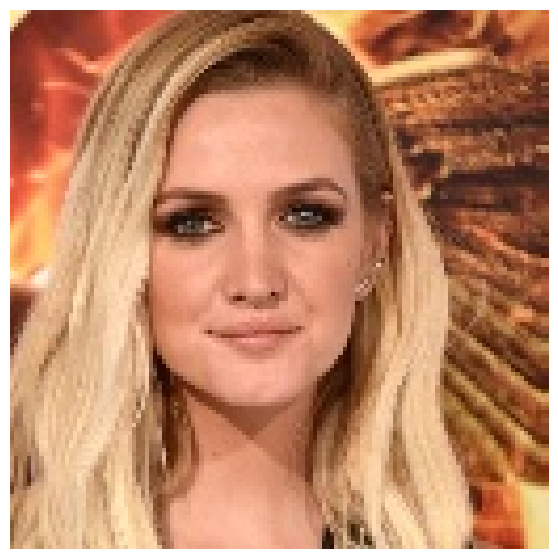

In [65]:
id = 250
softmax = nn.Softmax()
y_hat_id = softmax(model(test_dataset[id]['x'].to(DEVICE)))
def pred(x):
    for i in range(len(x[0])):
        if (x[0][i] == torch.max(x[0]).item()): 
            return i
true_age = train_dataset[id]['y'].item() + 20
print(f'image {id} is {true_age} years old and is predicted {pred(y_hat_id)+20} years old')
image = cv2.imread(test.iloc[id].Filepath)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
visualize(image)

In [48]:
PATH = r'/kaggle/working/C:\Users\DR\Downloads'
torch.save(model.state_dict(), PATH)


In [60]:
h =model.load_state_dict(torch.load(PATH))
model.eval()


AlexNetwork(
  (conv_1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(50, 50))
  (pool_1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool_2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool_3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (nn): Sequential(
    (0): Linear(in_features=9216, out_features=4096, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4096, out_features=4096, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4096, out_features=31, bias=True)
  )
)

In [66]:
with torch.no_grad():
    
    # Retrieve item
    index = 333
    item = dataset[index]
    image = item[0]
    true_target = item[1]
    
    # Loading the saved model
    save_path = './mlp.pth'
    mlp = MLP()
    mlp.load_state_dict(torch.load(save_path))
    mlp.eval()
    
    # Generate prediction
    prediction = mlp(image)
    
    # Predicted class value using argmax
    predicted_class = np.argmax(prediction)
    
    # Reshape image
    image = image.reshape(28, 28, 1)
    
    # Show result
    plt.imshow(image, cmap='gray')
    plt.title(f'Prediction: {predicted_class} - Actual target: {true_target}')
    plt.show()

NameError: name 'dataset' is not defined